# (Optional) Some aditional notes for the language detection process

In [ ]:
from langdetect import DetectorFactory, detect_langs
from collections import Counter
from datetime import date
import polars as pl
import random
import sys
import os

# Langdetect seed
DetectorFactory.seed = 0

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
import config
from paths import Paths
from src.lang_detect import detect_parallel

# change this for a dataset that you have
# date_obj = date(2025, 9, 10)
date_obj = date.today()
channel_paths = Paths(channel_handle=config.channel_handle, date_obj=date_obj)

Translate a single comment, remember to place the seed, to get consistent results across multiple runs

In [2]:
detect_langs("I love programming in python.")

[en:0.9999973504224122]

Tiny sample of what we will be translating

In [3]:
comments = pl.read_parquet(channel_paths.clean_comments_file_path, columns=["comment"], n_rows=5_000)["comment"].to_list()

Trying parallelization with different core count, the current results are from a test with an r5 5600x, a processor with 6 physical cores and 12 logical threads.

In [4]:
import platform
import psutil

def get_cpu_info():
    info = {
        "Processor Name": platform.processor(),
        "Physical Cores": psutil.cpu_count(logical=False),
        "Logical Cores (Threads)": psutil.cpu_count(logical=True),
        "Max Frequency (MHz)": psutil.cpu_freq().max,
        "Current Frequency (MHz)": psutil.cpu_freq().current,
        "Architecture": platform.machine(),
        "System": platform.system(),
        "Release": platform.release()
    }
    return info

cpu_info = get_cpu_info()

for key, value in cpu_info.items():
    print(f"{key}: {value}")

Processor Name: AMD64 Family 25 Model 33 Stepping 0, AuthenticAMD
Physical Cores: 6
Logical Cores (Threads): 12
Max Frequency (MHz): 3701.0
Current Frequency (MHz): 3701.0
Architecture: AMD64
System: Windows
Release: 10


## Running on all processor counts

### If you want you can also monitor the usage of your cpu
#### On windows - Task manager:
1) Task manager, Press `Ctrl + Shift + Esc` to open Task Manager
2) Go to **Performance Tab**.
3) Click on **CPU** in the left panel.

#### On Mac - Activity monitor:
1) Go to `Applications/Utilities`.
2) Go to **Window** -> **CPU Usage**

#### On Linux - htop
1) Open the terminal
2) Run `htop`, you can install it with `sudo apt install htop` for most linux distributions.

Now you can run the code bellow and observe the load on your system.

In [5]:
for processor_count in range(1, os.cpu_count() + 1):
    langs = detect_parallel(comments, max_workers=processor_count)
    print(f"Cores used {processor_count}")

  0%|          | 0/5000 [00:00<?, ?it/s]

Finished translation in 24.53s, 203.81 c/s
Cores used 1


  0%|          | 0/5000 [00:00<?, ?it/s]

Finished translation in 13.27s, 376.73 c/s
Cores used 2


  0%|          | 0/5000 [00:00<?, ?it/s]

Finished translation in 9.92s, 504.12 c/s
Cores used 3


  0%|          | 0/5000 [00:00<?, ?it/s]

Finished translation in 8.21s, 609.00 c/s
Cores used 4


  0%|          | 0/5000 [00:00<?, ?it/s]

Finished translation in 7.32s, 683.16 c/s
Cores used 5


  0%|          | 0/5000 [00:00<?, ?it/s]

Finished translation in 6.80s, 735.30 c/s
Cores used 6


  0%|          | 0/5000 [00:00<?, ?it/s]

Finished translation in 6.55s, 762.94 c/s
Cores used 7


  0%|          | 0/5000 [00:00<?, ?it/s]

Finished translation in 6.30s, 794.02 c/s
Cores used 8


  0%|          | 0/5000 [00:00<?, ?it/s]

Finished translation in 6.16s, 812.16 c/s
Cores used 9


  0%|          | 0/5000 [00:00<?, ?it/s]

Finished translation in 6.01s, 832.17 c/s
Cores used 10


  0%|          | 0/5000 [00:00<?, ?it/s]

Finished translation in 6.37s, 785.29 c/s
Cores used 11


  0%|          | 0/5000 [00:00<?, ?it/s]

Finished translation in 6.03s, 829.70 c/s
Cores used 12


In [ ]:
import pandas as pd

# Core scaling results
data = {
    'Cores': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
    'Throughput_cps': [204, 375, 513, 614, 698, 729, 768, 783, 772, 804, 815, 801],
    'CPU_Usage_%': [10, 30, 50, 60, 65, 70, 80, 90, 95, 100, 100, 100]  # Estimated from your task manager
}

df = pd.DataFrame(data)
df['Efficiency'] = df['Throughput_cps'] / df['Cores']
df

,Cores,Throughput_cps,CPU_Usage_%,Efficiency
0,1,204,10,204.000000
1,2,375,30,187.500000
2,3,513,50,171.000000
3,4,614,60,153.500000
4,5,698,65,139.600000
5,6,729,70,121.500000
6,7,768,80,109.714286
7,8,783,90,97.875000
8,9,772,95,85.777778
9,10,804,100,80.400000


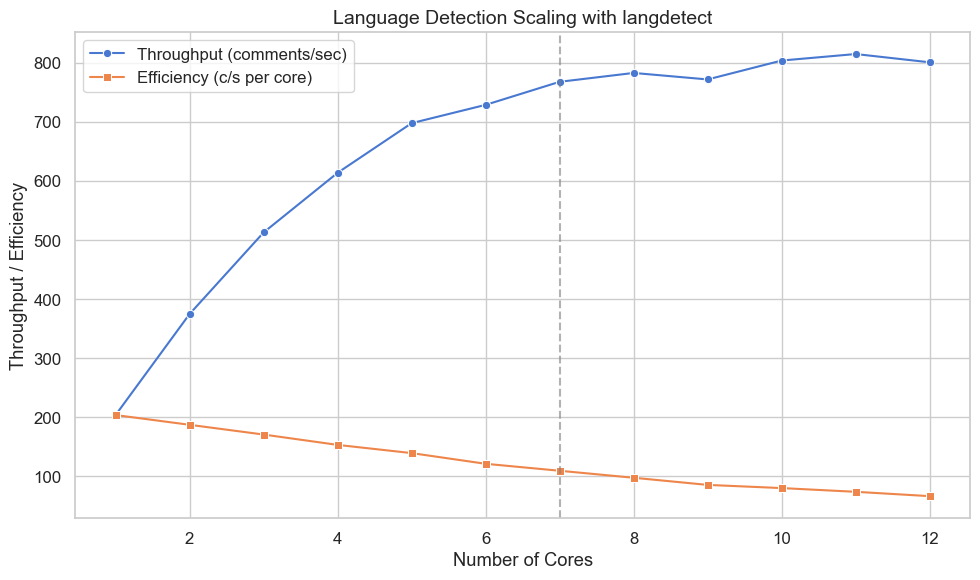

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid", palette="muted", font_scale=1.1)

fig, ax = plt.subplots(figsize=(10, 6))

# Throughput line
sns.lineplot(data=df, x='Cores', y='Throughput_cps', marker='o', label='Throughput (comments/sec)', ax=ax)

# Efficiency line
sns.lineplot(data=df, x='Cores', y='Efficiency', marker='s', label='Efficiency (c/s per core)', ax=ax)

ax.axvline(x=7, color='gray', linestyle='--', alpha=0.6)

# Labels
ax.set_title("Language Detection Scaling with langdetect", fontsize=14)
ax.set_xlabel("Number of Cores")
ax.set_ylabel("Throughput / Efficiency")
ax.legend()
plt.tight_layout()
# plt.show()

Check individual comments performance

In [12]:
res = list(zip(comments, langs))

In [17]:
random.sample(res, k = 3)

[('AB Monsur American Goatsbeard flowers, look them up. Also your silence towards my last comment (where I listed tons of facts supporting evolution) is noted.',
  'en'),
 ("Isn't a TARDIS a telephone booth? I don't see it.", 'en'),
 ('Sounds like this planet was terraformed and we are the result! 😅😂😂😅😂😂',
  'en')]

How many languages we've got?

In [21]:
Counter(langs).most_common(10)

[('en', 3994),
 ('und', 616),
 ('de', 56),
 ('so', 32),
 ('es', 24),
 ('fr', 22),
 ('tl', 21),
 ('id', 20),
 ('cy', 19),
 ('tr', 16)]

Note tha the "und" is not a small proportion. The library `langdetect` is not specially good in very short texts, and typos or slangs can confuse the model. For more accurate results, the use of other models is adviced, although langdetect is still useful due to its simplicity and multi platform friendliness.